In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

%config Completer.use_jedi = False

In [4]:
REBUILD_DATA = True  # to not reprocess everything

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "data/PetImages/Cat"
    DOGS = "data/PetImages/Dog"
    TESTING = "data/PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # np.eye creates an identity matrix (of dim 2)
                        
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                        
                    except Exception as e:
                        pass
                    
        np.random.shuffle(self.training_data)
        np.save("data/PetImages/training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [00:09<00:00, 1331.90it/s]


Cats: 12476
Dogs: 12470


In [2]:
training_data = np.load("data/PetImages/training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [3]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X / 255.0  # normalize
y = torch.Tensor([i[1] for i in training_data])

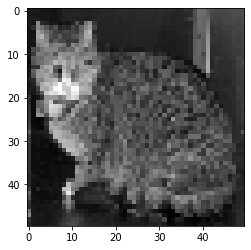

In [4]:
plt.imshow(X[0], cmap="gray")

In [5]:
y[0]

tensor([1., 0.])

# Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50) # small routine to get the flattening result
        self._to_linear = None  # todo: pytorch has a flatten method, it might work better
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        #print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

Net()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [4]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [5]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])

In [6]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [7]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

22452 2494


In [11]:
%%time

BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time.
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 225/225 [00:22<00:00,  9.86it/s]

Epoch: 0. Loss: 0.2097787857055664
CPU times: user 2min, sys: 2.52 s, total: 2min 2s
Wall time: 22.8 s


In [12]:
%%time

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:02<00:00, 922.30it/s]

Accuracy:  0.656
CPU times: user 15.5 s, sys: 28 ms, total: 15.6 s
Wall time: 2.71 s


# Run on GPU

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [9]:
device

device(type='cuda')

In [10]:
torch.cuda.device_count()

1

In [11]:
net = Net()

net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [33]:
%%time

EPOCHS = 1

def train(net, EPOCHS):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time.
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()

            optimizer.zero_grad()   # zero the gradient buffers
            
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net, EPOCHS)

100%|██████████| 225/225 [00:02<00:00, 80.65it/s]

Epoch: 0. Loss: 0.16366058588027954
CPU times: user 2.8 s, sys: 7.87 ms, total: 2.81 s
Wall time: 2.8 s


In [34]:
%%time

test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1674.32it/s]

Accuracy:  0.711
CPU times: user 1.5 s, sys: 3.92 ms, total: 1.5 s
Wall time: 1.49 s


In [35]:
%%time

EPOCHS = 3

train(net, EPOCHS)

  4%|▍         | 9/225 [00:00<00:02, 86.86it/s]

Epoch: 0. Loss: 0.1689344197511673


  4%|▍         | 9/225 [00:00<00:02, 87.57it/s]

Epoch: 1. Loss: 0.16862913966178894


100%|██████████| 225/225 [00:02<00:00, 81.73it/s]

Epoch: 2. Loss: 0.14693529903888702
CPU times: user 8.3 s, sys: 36.4 ms, total: 8.34 s
Wall time: 8.31 s


In [36]:
%%time

test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1692.30it/s]

Accuracy:  0.753
CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.47 s


# Model Analysis

In [12]:
def fwd_pass(X, y, net, optimizer, train=False):
    if train:
        net.zero_grad()
        
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]

    acc = matches.count(True) / len(matches)

    loss = loss_function(outputs, y)
        
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss        

In [13]:
def test(net, optimizer, size=32):
    
    random_start = np.random.randint(len(test_X) - size)
    X, y = test_X[random_start:random_start + size], test_y[random_start:random_start + size]
    
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device), net, optimizer)
        
    return val_acc, val_loss
    
val_acc, val_loss = test(net, optimizer)

print(val_acc, val_loss)

0.40625 tensor(0.2501, device='cuda:0')


In [14]:
MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)

print(MODEL_NAME)

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 8
    
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    with open("data/PetImages/model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i : i + BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i : i + BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, net, optimizer, train=True)
                
                if i % 50 == 0:
                    val_acc, val_loss = test(net, optimizer, size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train(net)

  2%|▏         | 4/225 [00:00<00:06, 34.21it/s]

model-1621888513


100%|██████████| 225/225 [00:05<00:00, 42.59it/s]


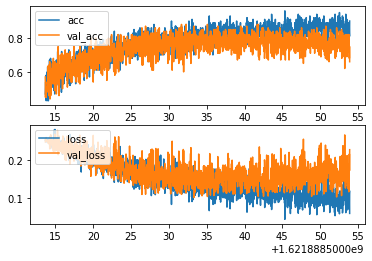

In [15]:
def create_acc_loss_graph(model_name):
    contents = open("data/PetImages/model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(MODEL_NAME)

In [ ]:
MODEL_NAME